Alpha_Vantage Tutorial & Examples
=================================

Uses RomelTorres' API wrapper from Github.

TimeSeries
----------

Used to get price data over a time frame. Defaults to integer, though
pandas df is more useful. Extended or adjusted pricing data (adjusts
prices retroactively for splits & dividends).


In [47]:
import datetime
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

# initialize av API
AV_API_KEY = 'AIDD24S6AW4MOOHG'


TimeSeries defaults to returning 2 .json files: data & metadata, but
using `output_format='pandas'` returns as pandas df instead of .json.
`outputsize` kwarg defaults to `'compact'`, which returns last 100
values, but setting to `'full'` returns all available data rows (>1 MB
file sizes).

            1. open  2. high  3. low  4. close  5. adjusted close   6. volume  \
date                                                                            
2021-01-06    80.58   82.737   80.31     82.38          82.380000  10039525.0   
2021-01-05    80.67   81.395   79.91     81.10          81.100000  10454680.0   
2021-01-04    82.00   82.090   79.88     80.96          80.960000  10021557.0   
2020-12-31    80.64   81.940   80.38     81.80          81.800000   5258719.0   
2020-12-30    81.66   81.730   80.54     80.59          80.590000   5661572.0   
...             ...      ...     ...       ...                ...         ...   
1999-11-05    79.94   81.130   79.50     80.38          36.754245   3816200.0   
1999-11-04    79.56   80.690   79.06     79.69          36.438738   4144900.0   
1999-11-03    79.44   80.880   78.75     79.13          36.182675   4428900.0   
1999-11-02    79.56   80.190   78.00     78.06          35.693411   3186000.0   
1999-11-01    78.94   79.940

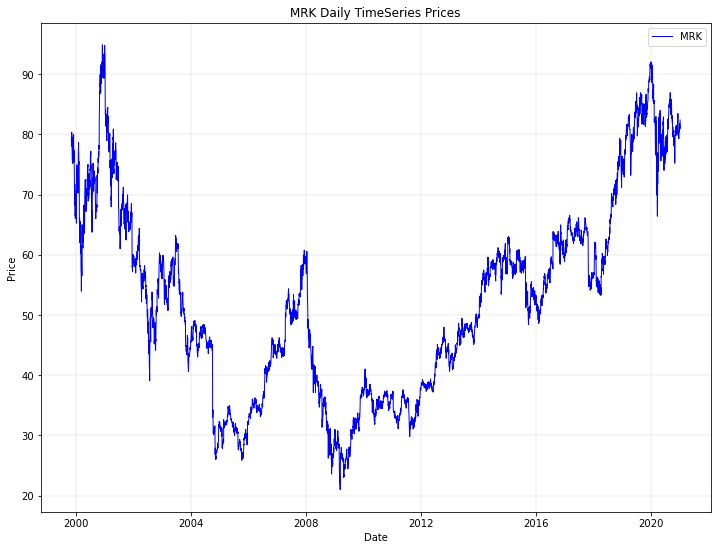

In [48]:
# Create MRK pandas df.
# type(data) = pd.Dataframe & type(metadata) = dict
ts = TimeSeries(key=AV_API_KEY, output_format='pandas')
data, metadata = ts.get_daily_adjusted('MRK', outputsize='full')
metadata = pd.Series(metadata, name='Metadata')  # metadata dict->Series
print(data)

# Plot daily closing prices for MRK.
merck_fig, merck_ax = plt.subplots(figsize=(12, 9))
merck_ax.plot(
    data.index,  # Series for x-axis values
    data['4. close'],  # Series of f(x) values
    '-b',  # solid blue lines, no individual markers
    linewidth=1,
    label='MRK'  # label in legend
)
merck_ax.set_title('MRK Daily TimeSeries Prices')
merck_ax.set_xlabel('Date')
merck_ax.set_ylabel('Price')
merck_ax.grid(b=True, linestyle='-', linewidth=0.25)
merck_ax.legend()

1. Information       Daily Time Series with Splits and Dividend Events
2. Symbol                                                          MRK
3. Last Refreshed                                           2021-01-06
4. Output Size                                               Full size
5. Time Zone                                                US/Eastern
Name: Metadata, dtype: object


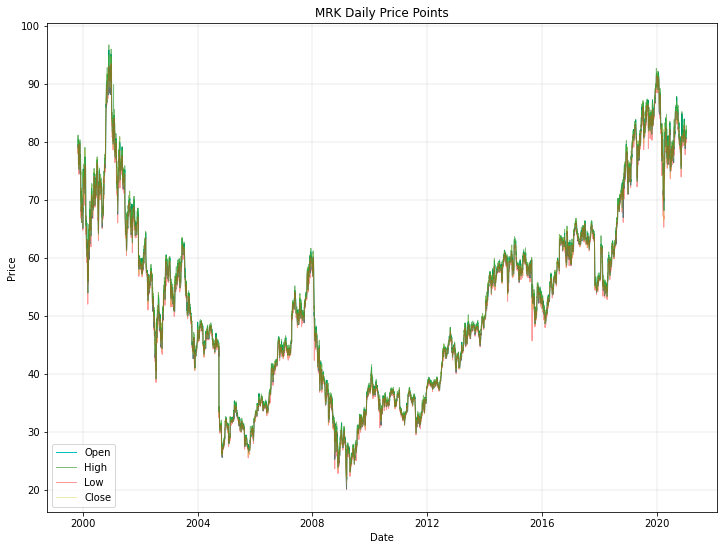

In [49]:
# Check MRK metadata.
print(metadata)

# Plot MRK open/close/hi/lo.
merck_fig, merck_ax = plt.subplots(figsize=(12, 9))
merck_ax.plot(
    # Plot daily open prices.
    data.index,
    data['1. open'],
    '-c',  # solid cyan line
    linewidth=1,
    label='Open'
)
merck_ax.plot(
    # Plot daily high prices.
    data.index,
    data['2. high'],
    '-g',  # solid green line
    linewidth=1,
    alpha=0.51,
    label='High'
)
merck_ax.plot(
    # Plot daily low prices.
    data.index,
    data['3. low'],
    '-r',  # solid red line
    linewidth=1,
    alpha=0.4,
    label='Low'
)
merck_ax.plot(
    # Plot daily close prides.
    data.index,
    data['4. close'],
    '-y',  # solid yellow line
    linewidth=1,
    alpha=0.3,
    label='Close'
)
merck_ax.set_title('MRK Daily Price Points')
merck_ax.set_xlabel('Date')
merck_ax.set_ylabel('Price')
merck_ax.grid(b=True, linestyle='-', linewidth=0.25)
merck_ax.legend()

Tech Indicators
---------------

In [53]:
ti = TechIndicators(AV_API_KEY, output_format='pandas')

# BBands tech indicators
data, metadata = ti.get_bbands(
    symbol='MRK',
    interval='daily',  # interval b/w consecutive values
    # Number of intervals to avg over, e.g. 90 = 90-day sliding avg.
    time_period=90
)
print(data.describe())
print(data)

       Real Upper Band  Real Middle Band  Real Lower Band
count      5241.000000       5241.000000      5241.000000
mean         41.002984         37.468393        33.933804
std          18.733236         17.706937        16.830661
min          17.916000         16.187400        10.673500
25%          27.085600         24.765200        22.041200
50%          35.209500         31.139700        27.846300
75%          51.441000         48.627500        45.355500
max          93.899700         83.895400        78.304000
            Real Upper Band  Real Middle Band  Real Lower Band
date                                                          
2021-01-06          85.0002           80.6312          76.2623
2021-01-05          85.0846           80.6550          76.2254
2021-01-04          85.1821           80.6899          76.1977
2020-12-31          85.2860           80.7279          76.1698
2020-12-30          85.3619           80.7537          76.1456
...                     ...          

In [51]:
# View metadata as Series
metadata = pd.Series(metadata, name='Metadata')
print(metadata)


1: Symbol                                                        MRK
2: Indicator                                Bollinger Bands (BBANDS)
3: Last Refreshed                                         2021-01-06
4: Interval                                                    daily
5: Time Period                                                    90
6.1: Deviation multiplier for upper band                           2
6.2: Deviation multiplier for lower band                           2
6.3: MA Type                                                       0
7: Series Type                                                 close
8: Time Zone                                         US/Eastern Time
Name: Metadata, dtype: object


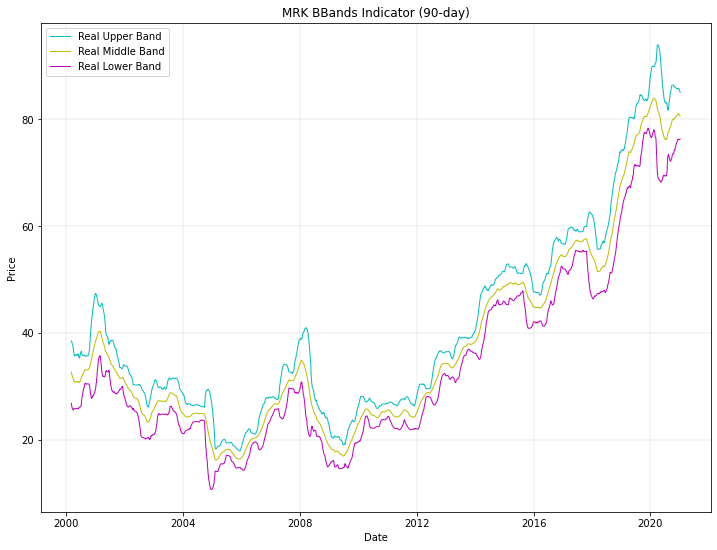

In [56]:
merck_fig = plt.figure(figsize=(12, 9))
gs = merck_fig.add_gridspec(nrows=1, ncols=1)  # 1x1 set of axes

# Create subplot at specified coords & assign to axis
merck_ax = merck_fig.add_subplot(gs[0,0])
merck_ax.plot(
    # Plot daily open prices.
    data.index,
    data['Real Upper Band'],
    '-c',
    linewidth=1,
    label='Real Upper Band'
)
merck_ax.plot(
    # Plot daily open prices.
    data.index,
    data['Real Middle Band'],
    '-y',
    linewidth=1,
    label='Real Middle Band'
)
merck_ax.plot(
    # Plot daily open prices.
    data.index,
    data['Real Lower Band'],
    '-m',
    linewidth=1,
    label='Real Lower Band'
)
merck_ax.set_title('MRK BBands Indicator (90-day)')
merck_ax.set_xlabel('Date')
merck_ax.set_ylabel('Price')
merck_ax.grid(b=True, linestyle='-', linewidth=0.25)
merck_ax.legend()
